<a href="https://colab.research.google.com/github/n54hayden/cap-comp215/blob/main/Project2Working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import animation
import time

In [21]:
"""Creating the Grazing object"""
class GrazingCA:
    EMPTY = 0
    GRASS = 1
    DEER = 2

    cmap = ['beige', 'green', 'brown']
    grazing_cmap = ListedColormap(cmap)

    #initialization, as per usual
    def __init__(self, n, initial_deer, grass_regeneration_rate, deer_move_prob, deer_eat_prob):
        self.n = n
        self.grass_regeneration_rate = grass_regeneration_rate
        self.deer_move_prob = deer_move_prob
        self.deer_eat_prob = deer_eat_prob
        self.state = np.zeros((n, n), dtype=int)
        self.initialize_state(initial_deer)

        # Lists to store population data over time
        self.deer_population = [initial_deer]
        self.grass_population = [self.get_grass_population()]

    def initialize_state(self, initial_deer):
      self.state[:, :] = self.EMPTY
      for _ in range(initial_deer):
          x, y = np.random.randint(0, self.n), np.random.randint(0, self.n)
          self.state[x, y] = self.DEER
      self.initial_grass_distribution()

    def initial_grass_distribution(self):
        initial_grass = int(self.n * self.n * self.grass_regeneration_rate)
        for _ in range(initial_grass):
            x, y = np.random.randint(0, self.n), np.random.randint(0, self.n)
            while self.state[x, y] != self.EMPTY:
                x, y = np.random.randint(0, self.n), np.random.randint(0, self.n)
            self.state[x, y] = self.GRASS

    #I created a separate regenerate_grass function with help from AI because I was having troubles making the grass generate after the first timestep
    def regenerate_grass(self):
        for i in range(self.n):
            for j in range(self.n):
                if self.state[i, j] == self.EMPTY and np.random.rand() < self.grass_regeneration_rate:
                    self.state[i, j] = self.GRASS

    #These two functions are used to find the population of the deer and the grass in order to create a chart.
    def get_deer_population(self):
        return np.sum(self.state == self.DEER)

    def get_grass_population(self):
        return np.sum(self.state == self.GRASS)

    #The step function. This was originally done with a Kernel but I kept having errors. The change was suggested by AI.
    def step(self):
      new_state = np.copy(self.state) #Creates a copy of the current grid
      for i in range(self.n): #Iterates ober rows
          for j in range(self.n): #Iterates over column
              if self.state[i, j] == self.DEER:
                  new_state[i, j] = self.EMPTY #Sets to empty as deer either eats grass or moves
                  dx, dy = np.random.choice([-1, 0, 1]), np.random.choice([-1, 0, 1]) #Chooses a random directions for deer to move in
                  if 0 <= i + dx < self.n and 0 <= j + dy < self.n and np.random.rand() < self.deer_move_prob:
                      new_state[i + dx, j + dy] = self.DEER #If within grid boundaries move to the selected cell
                  if np.random.rand() < self.deer_eat_prob: #Checks if deer eats grass
                      for di in range(-1, 2):
                          for dj in range(-1, 2):
                              ni, nj = i + di, j + dj
                              if 0 <= ni < self.n and 0 <= nj < self.n and self.state[ni, nj] == self.GRASS:
                                  new_state[ni, nj] = self.DEER #Checks if neighboring cells contain grass. If they do, the cell becomes a deer cell as the deer "reproduces"
              elif self.state[i, j] == self.GRASS:
                  if np.random.rand() < self.grass_regeneration_rate:
                      new_state[i, j] = self.GRASS
      self.state = new_state #Updates the state with the new state
      self.regenerate_grass()

      # Update population data
      self.deer_population.append(self.get_deer_population())
      self.grass_population.append(self.get_grass_population())

    def draw(self):
        plt.figure(figsize=(8, 8))
        plt.imshow(self.state, cmap=self.grazing_cmap, interpolation='nearest')
        plt.axis('off')
        plt.show()

In [22]:
class AnimationGrazing:

    def __init__(self, model, frames=50, steps_per_frame=1):
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=(8, 8))

    def animate(self, interval=None):
        from IPython.display import clear_output

        try:
            for i in range(self.frames):
                clear_output(wait=True)
                self.animation_step(i)
                plt.show()
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass


    def animation_step(self, step):
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.ax.clear()
        self.model.draw()


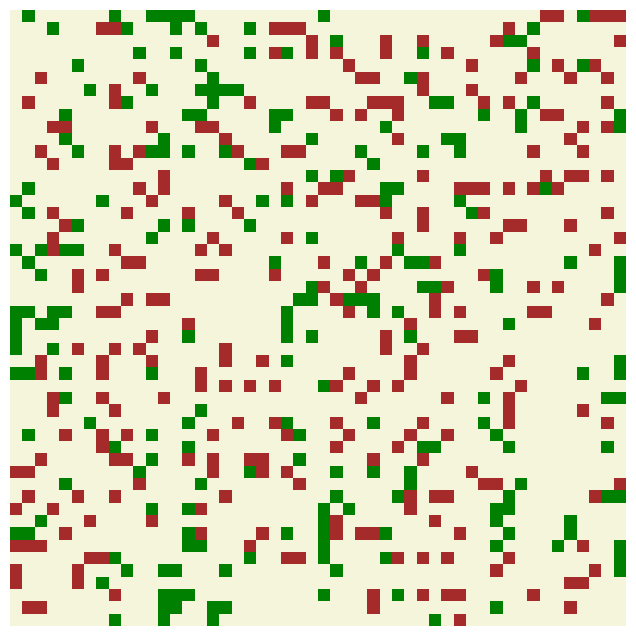

In [23]:
n = 50 #Grid size
initial_deer = 20
grass_regeneration_rate = 0.05
deer_move_prob = 0.8
deer_eat_prob = 1

grazing_model = GrazingCA(n, initial_deer, grass_regeneration_rate, deer_move_prob, deer_eat_prob)

grazing_animation = AnimationGrazing(grazing_model, frames=100, steps_per_frame=1)

grazing_animation.animate(interval=0.3)

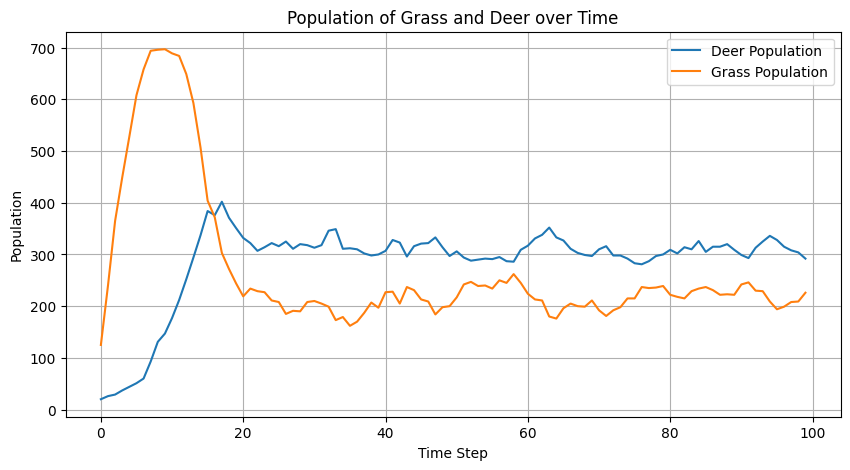

In [24]:
import matplotlib.pyplot as plt
import numpy as np

"""Plot showing the population on grass and population of deer over time"""

plt.figure(figsize=(10, 5)) #Size of the plot
plt.plot(range(len(grazing_model.deer_population)), grazing_model.deer_population, label='Deer Population')
plt.plot(range(len(grazing_model.grass_population)), grazing_model.grass_population, label='Grass Population')
plt.xlabel('Time Step')
plt.ylabel('Population')
plt.title('Population of Grass and Deer over Time')
plt.legend()
plt.grid(True)
plt.show()

This model tells us that a grazing system is self-regulating: When there is an abundance of grass, the deer population quickly grows. As the population grows, the amount of grass depletes which in turn causes the deer population to decrease. Over time, the deer population and the amount of grass reach a stable state where there is enough grass regenerating to support a relatively fixed deer population.

The chart above demonstrates the influxes in population of grass and deer in the beginning, which stabilizes as time increases.

If I had more time, I would introduce other variables to create a more realistic scenario. Some examples are predators like wolves whose population is dependent on the amount of deer, which in turn affects the amount of grass present, or a weather cycle where there is less grass present during certain times.


The Big-O time complexity of this algorithm is O(n x m x t). This is because for each time step, t, the grid, n x m, needs to be iterated over to update its state, so updating the grid every timestep gives us O((n x m ) x t). Due to this time complexity, as you increase the size of the grid or the amount of time steps, the time it takes and the computational resources increase by a large amount.

In [25]:
import timeit

# Function to run the basic CA simulation with given parameters. A little bit of help from AI.
def run_basic_simulation(n, m, t):
    setup_code = f"""
from __main__ import GrazingCA
n = {n}
m = {m}
t = {t}
initial_deer = int({n} * {m} * 0.1)  # Assuming 10% of cells initially have deer
grass_regeneration_rate = 0.5
deer_move_prob = 0.8
deer_eat_prob = 0.5
grazing_model = GrazingCA(n * m, initial_deer, grass_regeneration_rate, deer_move_prob, deer_eat_prob)
"""
    timing_code = """
for _ in range(t):
    grazing_model.step()
"""
    time_taken = timeit.timeit(stmt=timing_code, setup=setup_code, number=1)
    return time_taken

In [26]:
# Test the function for a small grid size and fewer time steps
time_taken_small = run_basic_simulation(n=10, m=10, t=25)
print(f"Time taken for a small grid and fewer time steps: {time_taken_small} seconds")

Time taken for a small grid and fewer time steps: 1.1424413099998674 seconds


In [27]:
# Test the function for a larger grid size and more time steps
time_taken_large = run_basic_simulation(n=20, m=20, t=50)
print(f"Time taken for a larger grid and more time steps: {time_taken_large} seconds")

Time taken for a larger grid and more time steps: 43.9189659650001 seconds


While there are some improvements to efficiency seen in the Chapter 8 Notebook, the improvements aim to  reduce the multiplicative coefficient which makes excecution times faster for larger grids and timesteps. This does increase the efficiency of the algorithm, but does not have an effect on the Big-O time complexity.